In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io
from scipy import stats
import glob
from os import listdir
from os.path import isfile, join
from datetime import datetime
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
import time
import pickle
from hurst import compute_Hc
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import auc, precision_recall_curve, log_loss,confusion_matrix, recall_score, precision_score, accuracy_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

plt.style.use('dark_background')
#plt.style.use('ggplot')

#### Funções

In [102]:
def split_data(df, split, targed = 'close'):
    '''Recebe um dataframe e um int para definir quantos dados serão para treinamento e a coluna da variável alvo'''
    X_train = df.drop('close', axis = 1).iloc[:split]
    y_train = np.sign(df.close).iloc[:split]
    X_test = df.drop('close', axis = 1).iloc[split:]
    y_test = np.sign(df.close).iloc[split:]
    return X_train, y_train, X_test, y_test

def add_lags(data, coluna, lags, prefix):
    '''Recebe um dataframe, uma coluna, uma quantidade de lags e um prefixo e retorna um dataframe'''
    cols = []
    df = data.copy()
    for lag in range(1, lags+1):
        col = f'lag_{lag}_{prefix}'
        df[col] = data[coluna].shift(lag)
        cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [2]:
data = pd.read_csv(r'C:\Users\VictorBoscaro\Desktop\Estudos - True\TCC\Dados\btc_usd_2020.csv', header = 1)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688300 entries, 0 to 688299
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unix Timestamp  688300 non-null  int64  
 1   Date            688300 non-null  object 
 2   Symbol          688300 non-null  object 
 3   Open            688300 non-null  float64
 4   High            688300 non-null  float64
 5   Low             688300 non-null  float64
 6   Close           688300 non-null  float64
 7   Volume          688300 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 42.0+ MB


## Resumo
<br>

Neste notebook será encontrado uma base de dados com informações a respeito do preço do bitcoin no ano de 2020. Sua granularidade é por minuto. Sim, é dado para um caralho. E aparentemente eles estão limpos.
<br>

O preço do bitcoin se da em dólares. 
<br><br>

### Um breve resumo 
- 680300 observações
- 0 informações nulas

<br>
Para fins de experimentação, e para meu computador não explodir, as agragações nesse notebook serão feita num período de 3 meses. <br>
        - Agora (21/05) que a elo me mandou um notebook bom talvez não exploda tão fácil.

<br><br>
Esse períododo será de Janeiro de 2021 até Março de 2021. Isso nos deixa com:
- 4320 observações

<br><br>

### To-Do
- Outlier Score - Procurar 
- Adicionar informação das horas/minutos como features

## Uma rápida olhada nos dados

In [5]:
data.describe()

,Unix Timestamp,Open,High,Low,Close,Volume
count,6.883000e+05,688300.000000,688300.000000,688300.000000,688300.000000,688300.000000
mean,1.599545e+12,21368.095247,21381.808814,21354.050018,21368.163591,1.546407
std,1.240559e+10,17905.220942,17918.864408,17890.634892,17905.262539,6.146906
min,1.577837e+12,3935.290000,3939.260000,3901.250000,3935.290000,0.000000
25%,1.588766e+12,9218.437500,9220.837500,9216.830000,9218.440000,0.024204
50%,1.599694e+12,11311.520000,11315.000000,11307.590000,11311.520000,0.198683
75%,1.610365e+12,32820.725000,32856.735000,32781.090000,32820.815000,1.036505
max,1.620691e+12,64890.000000,64900.000000,64775.620000,64890.000000,1043.579964


In [3]:
data.columns = map(lambda x: x.casefold().replace(' ', '_'), data.columns)
data['date'] = pd.to_datetime(data.date)
data.set_index('date', inplace = True)

In [8]:
data.isnull().sum()

unix_timestamp    0
symbol            0
open              0
high              0
low               0
close             0
volume            0
dtype: int64

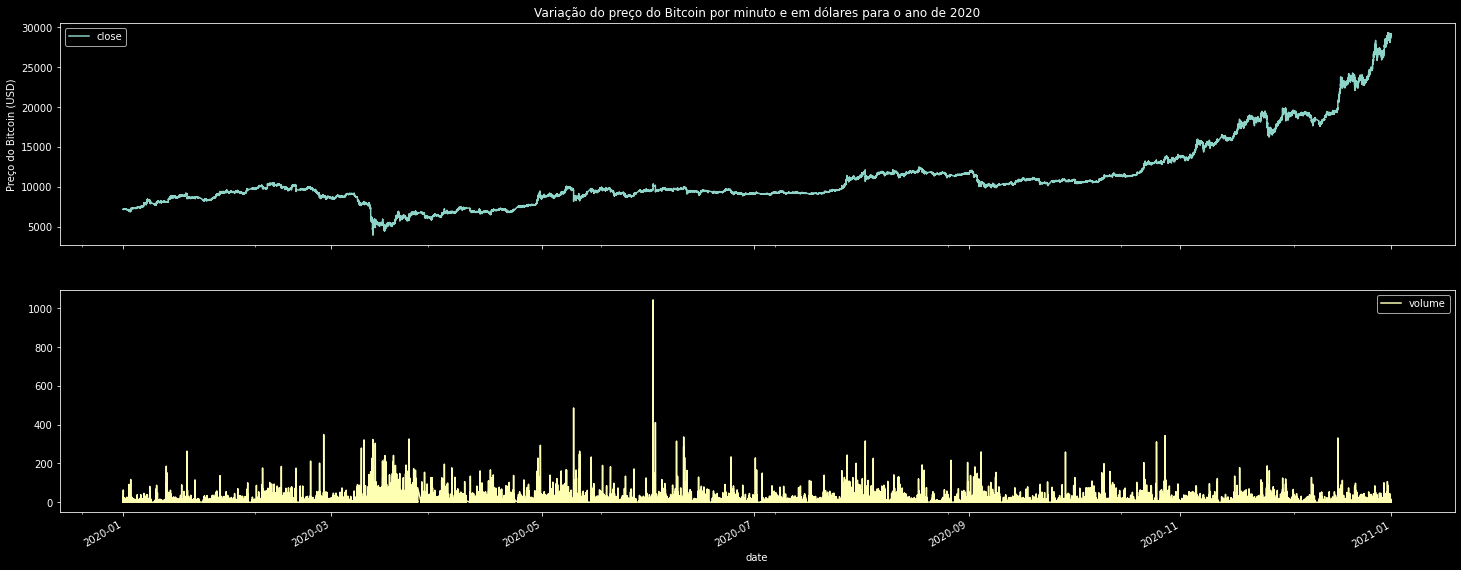

In [4]:
data_20 = data[data.index.year == 2020]
axes = data_20[['close', 'volume']].plot(figsize=(25,10), subplots = True)
for ax in axes:
    ax.set_xlabel('Data')
    ax.set_ylabel('Preço do Bitcoin (USD)')
    ax.set_title('Variação do preço do Bitcoin por minuto e em dólares para o ano de 2020')
    plt.show()

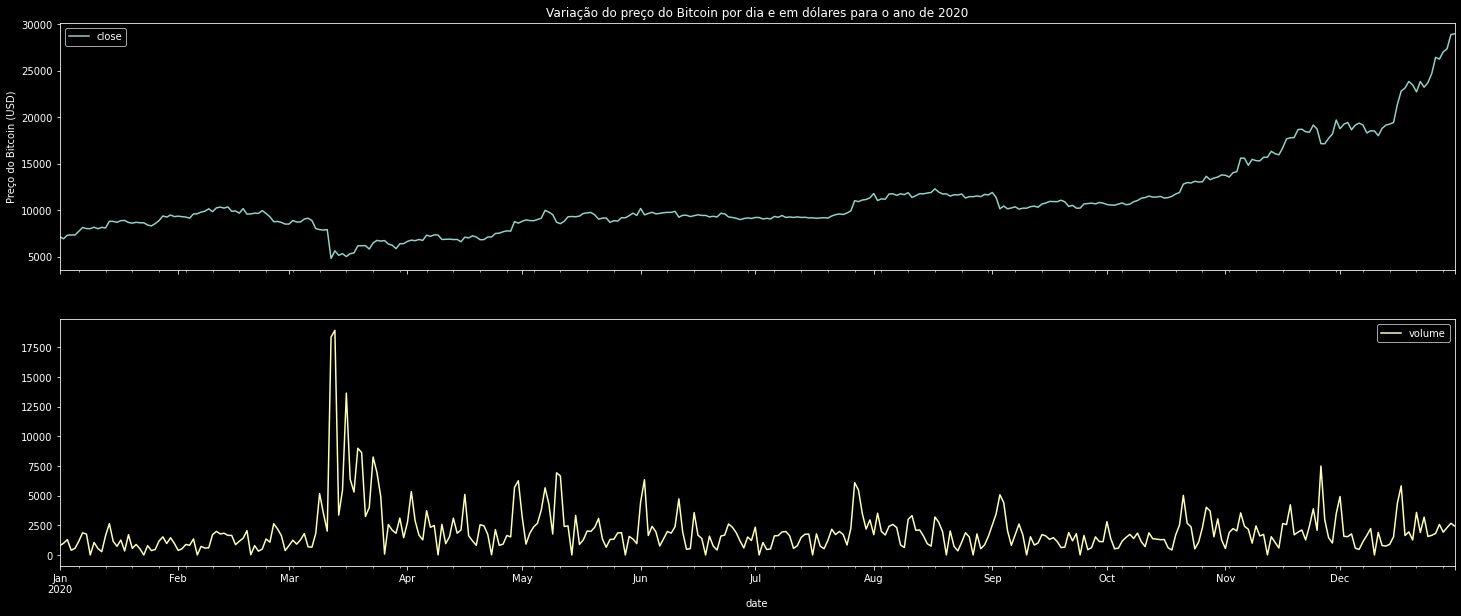

In [26]:
price_by_day = data_20.close.resample('D').apply(lambda ser: ser.iloc[-1,])
volume_by_day = data_20.volume.resample('D').sum()
resampled_by_day = pd.merge(left = price_by_day, right = volume_by_day, left_index = True, right_index = True)
axes = resampled_by_day[['close', 'volume']].plot(figsize=(25, 10), subplots = True)
for ax in axes:
    ax.set_xlabel('Data')
    ax.set_ylabel('Preço do Bitcoin (USD)')
    ax.set_title('Variação do preço do Bitcoin por dia e em dólares para o ano de 2020')
    plt.show()

In [ ]:
decomposition = seasonal_decompose(indexedDataset_logScale)

In [13]:
data_20.close.resample('M').min()

date
2020-01-31     6860.55
2020-02-29     8430.00
2020-03-31     3935.29
2020-04-30     6162.18
2020-05-31     8175.01
2020-06-30     8846.23
2020-07-31     8938.55
2020-08-31    10664.95
2020-09-30     9880.71
2020-10-31    10398.93
2020-11-30    13249.69
2020-12-31    17599.26
Freq: M, Name: close, dtype: float64

### Variáveis importantes

In [7]:
data_20 = data[data.index.year == 2020].dropna()
close = data_20.close.to_frame()
change = data_20.close.pct_change().to_frame().dropna()
volume_change = data_20.volume.diff().dropna().to_frame().dropna()

## Transformando os dados em estacionários

In [11]:
adfuller(close.iloc[:50000])

(-2.1099605410106252,
 0.2405283265126033,
 18,
 49981,
 {'1%': -3.4304808424377145,
  '5%': -2.861597829669839,
  '10%': -2.566800780820739},
 467595.30907008325)

In [40]:
adfuller(change.iloc[:50000])

(-74.06412114952913,
 0.0,
 9,
 49990,
 {'1%': -3.4304808188801545,
  '5%': -2.861597819258111,
  '10%': -2.5668007752788804},
 -532178.0302987061)

In [9]:
df_price, cols_price = add_lags(change, 'close', 5, 'price')
df_volume, cols_price = add_lags(volume_change, 'volume', 5, 'volume')

In [10]:
data = pd.merge(left = df_price, right = df_volume, left_index = True, right_index = True)
data.drop('volume', axis = 1, inplace = True)

## Adicionando uma variável que indica se a observação é um outlier ou não 

In [ ]:
def is_outlier(df, samples = -400000):
    '''Recebe um dataframe e indica se as observações são outlier'''
    outliers = LocalOutlierFactor(novelty = True)
    x_train = df.iloc[-400000:]
    outliers_model = outliers.fit(x_train)
    x_test = df[~df.index.isin(x_train.index)]
    predict = outliers_model.predict(x_test)
    x_test['outlier'] = predict
    x_test['outlier'] = x_test.outlier.map({1:1, -1:0})
    return x_test

In [11]:
outliers = LocalOutlierFactor(novelty = True)
x_train = data.iloc[-400000:]
outliers_model = outliers.fit(x_train)

In [12]:
x_test = data[~data.index.isin(x_train.index)]

In [13]:
predict = outliers_model.predict(x_test)

In [14]:
x_test['outlier'] = predict
x_test['outlier'] = x_test.outlier.map({1:1, -1:0})

<ipython-input-14-90fb4b478501>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['outlier'] = predict
<ipython-input-14-90fb4b478501>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['outlier'] = x_test.outlier.map({1:1, -1:0})


In [15]:
model_data = x_test[x_test.close != 0].sort_index()

## Treinando alguns modelos
<br>

- Esse foi um teste de classificação. O objetivo foi prever se o preço no próximo período (minuto) iria subir ou descer.

<br>

1 - Variáveis utilizadas:

- Lagged values da variaçao de preço em 5 períodos
- Lagged values da variação de volume em 5 períodos
- Indicador gerado por um modelo não supervisionado indicando se aquela observação é outlier ou não
- Uma sessão de treino foi feita com variáveis categóricas que indicavam se a variação foi positiva ou negativa
- Uma outra sessão foi feita com os valores em percentual da variação de um período para o outro

<br>

### Treinamento com variáveis categóricas
<br>

- Regressão Logística apresentou o melhor resultado
    - Acurácia - 51.28%
    - Precisão - 51.51%
    - Recall   - 45.47%
    - AUC      - 51.28%
   
<br>

### Treinamento com variáveis contínuas
<br>

- Random Forest apresentou o melhor resultado
    - Acurácia - 52.02%
    - Precisão - 52.12%
    - Recall   - 50.99%
    - AUC      - 52.02%

## Treinando com dados categóricos (subiu ou desceu)

In [312]:
models = {'logit':LogisticRegression(), 'rf':RandomForestClassifier(), 'dt':DecisionTreeClassifier(), 'knn':KNeighborsClassifier()}

In [14]:
split = 80000
X_train_sign = np.sign(model_data.drop('close', axis = 1)).iloc[:split]
y_train_sign = np.sign(model_data.close).iloc[:split]
X_test_sign = np.sign(model_data.drop('close', axis = 1)).iloc[split:]
y_test_sign = np.sign(model_data.close).iloc[split:]

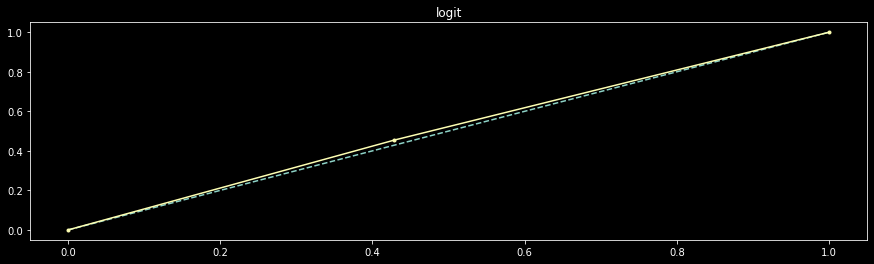

AttributeError: predict_proba is not available when  probability=False

In [314]:
dic = {}
pred_dic = {}
for key, model in models.items():    
    clf = models[key]
    clf.fit(X_train_sign, y_train_sign)
    y_pred_sign = clf.predict(X_test_sign)
    y_pred_prob = clf.predict_proba(X_test_sign)
    accuracy = accuracy_score(y_test_sign, y_pred_sign)
    precision = precision_score(y_test_sign, y_pred_sign)
    recall = recall_score(y_test_sign, y_pred_sign)
    fpr, tpr, thresholds = roc_curve(y_test_sign, y_pred_sign)
    au_curve = auc(fpr, tpr)
    tn, fp, fn, tp = confusion_matrix(y_test_sign, y_pred_sign).ravel()
    metricas = [accuracy, precision, recall, au_curve, tn, fp, fn, tp]
    dic[key] = metricas
    pred_dic[key] = [{'pred_prob':y_pred_prob, 'pred_sign':y_pred_sign}]
    plt.rcParams["figure.figsize"] = (15,4)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=key)
    plt.title(key)
    plt.show()

In [303]:
df = pd.DataFrame(dic, index = ['accuracy', 'precision', 'recall', 'auc', 'true_negative', 'false_positive', 'false_negative', 'true_positive']).T

In [304]:
df

,accuracy,precision,recall,auc,true_negative,false_positive,false_negative,true_positive
logit,0.512827,0.515169,0.454709,0.512894,4447.0,3340.0,4256.0,3549.0
rf,0.509043,0.509561,0.512108,0.509040,3940.0,3847.0,3808.0,3997.0
dt,0.510518,0.511644,0.486996,0.510545,4159.0,3628.0,4004.0,3801.0
knn,0.497114,0.497473,0.453940,0.497164,4208.0,3579.0,4262.0,3543.0


## Treinando com dados contínuos (variação do preço)

In [328]:
split = 80000
X_train = model_data.drop('close', axis = 1).iloc[:split]
y_train = np.sign(model_data.close).iloc[:split]
X_test = model_data.drop('close', axis = 1).iloc[split:]
y_test = np.sign(model_data.close).iloc[split:]

In [138]:
def train_test_and_save_model(clf, X_train, X_test, y_train, y_test, comment):
    clf.fit(X_train, y_train)
    y_pred_sign = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred_sign)
    precision = precision_score(y_test, y_pred_sign)
    recall = recall_score(y_test, y_pred_sign)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_sign)
    au_curve = auc(fpr, tpr)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_sign).ravel()
    metricas = [accuracy, precision, recall, au_curve, tn, fp, fn, tp]
    df_temp = pd.DataFrame(metricas, index = ['accuracy', 'precision', 'recall', 'au_curve', 'tn', 'fp', 'fn', 'tp']).T
    df_temp['comentario'] = comment
    df_metricas = pd.read_excel(r'C:\Users\VictorBoscaro\Desktop\Estudos - True\TCC\Dados\Parametros Modelos\metricas_modelos.xlsx')
    df_metricas = pd.concat([df_temp, df_metricas], axis = 0)
    df_metricas.to_excel(r'C:\Users\VictorBoscaro\Desktop\Estudos - True\TCC\Dados\Parametros Modelos\metricas_modelos.xlsx')
    del(df_metricas)
    return clf, df_temp

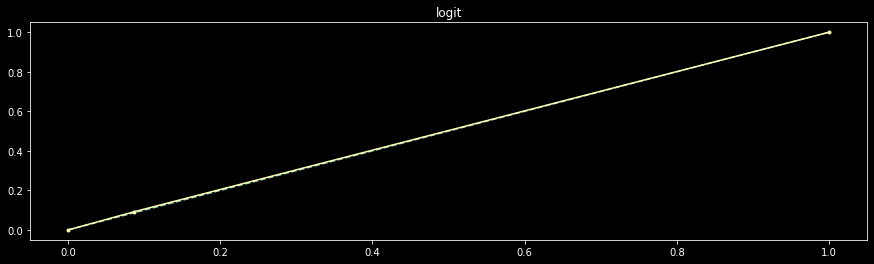

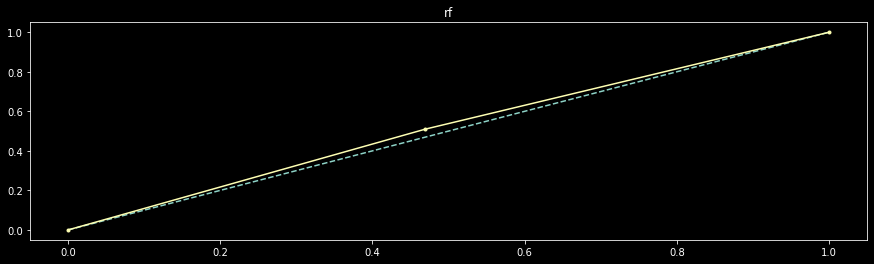

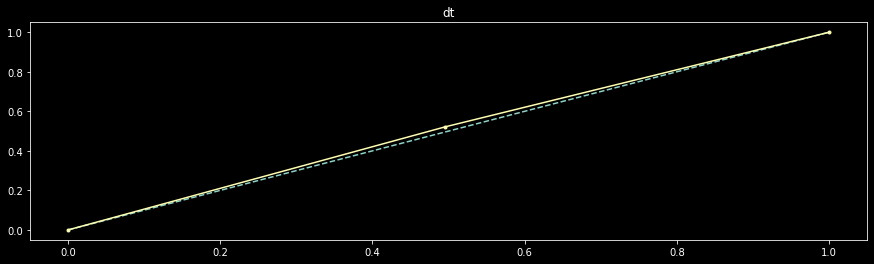

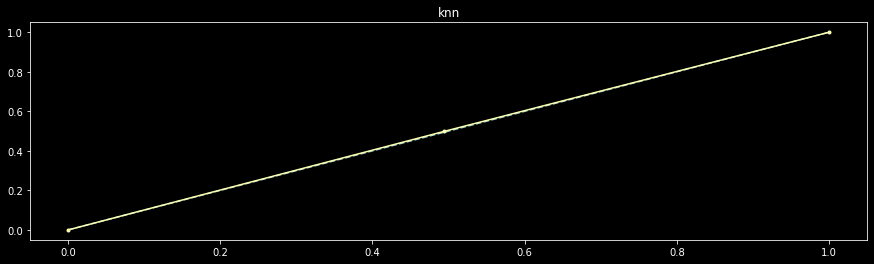

In [310]:
dic_cont = {}
pred_dic_cont = {}
for key, model in models.items():    
    clf = models[key]
    clf.fit(X_train, y_train)
    y_pred_sign = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred_sign)
    precision = precision_score(y_test, y_pred_sign)
    recall = recall_score(y_test, y_pred_sign)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_sign)
    au_curve = auc(fpr, tpr)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_sign).ravel()
    metricas = [accuracy, precision, recall, au_curve, tn, fp, fn, tp]
    dic_cont[key] = metricas
    pred_dic_cont[key] = [{'pred_prob':y_pred_prob, 'pred_sign':y_pred_sign}]
    plt.rcParams["figure.figsize"] = (15,4)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=key)
    plt.title(key)
    plt.show()

In [311]:
df = pd.DataFrame(dic_cont, index = ['accuracy', 'precision', 'recall', 'auc', 'true_negative', 'false_positive', 'false_negative', 'true_positive']).T
df

,accuracy,precision,recall,auc,true_negative,false_positive,false_negative,true_positive
logit,0.502181,0.515457,0.091864,0.502655,7113.0,674.0,7088.0,717.0
rf,0.520203,0.521215,0.509930,0.520215,4131.0,3656.0,3825.0,3980.0
dt,0.512955,0.513306,0.521461,0.512946,3928.0,3859.0,3735.0,4070.0
knn,0.502181,0.502781,0.498014,0.502185,3943.0,3844.0,3918.0,3887.0


## Treinando um modelo de Random Forest
<br>

- Será adicionada uma nova variável categórica, indicando qual é o período do dia.
    - 00 até 05: madrugada
    - 06 até 11: manhã
    - 12 até 17: tarde
    - 18 até 23: noite
    
    
### Métricas
<br>

- A RandomForest foi treinada com os seguintes parâmetros:
    - n_estimators = 200, min_samples_split = 5, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 10, bootstrap = True

- Métricas: 
    - Acurácia: 52.71%
    - Precisão: 52.78%
    - Recall  : 52.46%
    - AUC     : 52.71%

In [45]:
bins = [-1, 5, 11, 17, 23]
labels = ['madrugada', 'manha', 'tarde', 'noite']
model_data.loc[:, 'periodo'] = pd.cut(model_data.index.hour, bins = bins, labels = labels)

dummies = pd.get_dummies(model_data.periodo)
model_data_per = pd.merge(left = model_data, right = dummies, left_index = True, right_index = True)

model_data_per = model_data_per.drop('periodo', axis = 1)

In [100]:
X_train, y_train, X_test, y_test = split_data(model_data_per, split = 80000)

In [20]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [26]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  36.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  36.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  35.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 2.8min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 2.8min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 2.7min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=6

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 7.4min
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 7.4min
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time= 7.3min
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; total time= 3.4min
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; total time= 3.4min
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1200; total time= 3.4min
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time= 4.1min
[CV] END bootstrap=True, max_depth=11

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=30,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [29]:
best_params = rf_random.best_params_
rf_random.best_score_

0.5225624575065195

In [86]:
best_params_df = pd.DataFrame(best_params, index = ['Params'])
best_params_df['situacao'] = 'modelo treinado com valores lagados de volume e preço, variável indicando se observação é outlier e informação sobre o periodo do dia'
best_params_df.to_csv(r'C:\Users\VictorBoscaro\Desktop\Estudos - True\TCC\Dados\Parametros Modelos\random_forest_1_params.csv')

In [110]:
X_train, y_train, X_test, y_test = split_data(model_data_per, split = 80000)
rf_classifier = RandomForestClassifier(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 10, bootstrap = True)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [105]:
X_train.head()

,lag_1_price,lag_2_price,lag_3_price,lag_4_price,lag_5_price,lag_1_volume,lag_2_volume,lag_3_volume,lag_4_volume,lag_5_volume,outlier,madrugada,manha,tarde,noite
date,,,,,,,,,,,,,,,
2020-10-20 18:24:00,0.000066,0.000069,0.000893,-0.000707,-0.000206,0.983445,-4.868414,5.143987,-0.069032,-0.652391,1,0,0,0,1
2020-10-20 18:25:00,0.000069,0.000893,-0.000707,-0.000206,-0.000570,-4.868414,5.143987,-0.069032,-0.652391,-3.823166,1,0,0,0,1
2020-10-20 18:26:00,0.000893,-0.000707,-0.000206,-0.000570,-0.000002,5.143987,-0.069032,-0.652391,-3.823166,4.621141,1,0,0,0,1
2020-10-20 18:27:00,-0.000707,-0.000206,-0.000570,-0.000002,-0.000702,-0.069032,-0.652391,-3.823166,4.621141,-0.045764,1,0,0,0,1
2020-10-20 18:28:00,-0.000206,-0.000570,-0.000002,-0.000702,0.000041,-0.652391,-3.823166,4.621141,-0.045764,0.023437,1,0,0,0,1


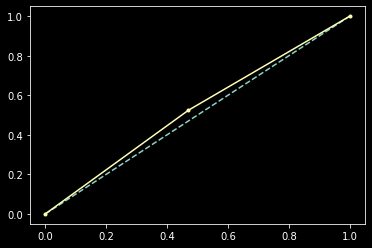

In [112]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
au_curve = auc(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')

## Adicionando Informação sobre o Indíce de Hurst

In [129]:
def create_hurst_vars(dataframe, hurst_samples):
    '''Recebe um dataframe e um int. O dataframe será usado para calcular o Indíce de Hurst, e o int será o número de amostras utilizadas para calcula-lo'''
    hursts = {}
    for i in range(hurst_samples, len(dataframe) - hurst_samples):
        filtered = dataframe.close.iloc[i-hurst_samples:i]
        idx = filtered.index[-1]
        hurst = compute_Hc(filtered)[0]
        hursts[idx] = hurst
    hurst_exponent = pd.DataFrame(hursts, index = ['hurst']).T
    return hurst_exponent

In [130]:
hurst = create_hurst_vars(model_data_per, 200)

In [131]:
model_data_hurst = pd.merge(left = model_data_per, right = hurst, left_index = True, right_index = True)

In [132]:
X_train, y_train, X_test, y_test = split_data(model_data_hurst, split = 80000)

In [139]:
X_train.head(1)

,lag_1_price,lag_2_price,lag_3_price,lag_4_price,lag_5_price,lag_1_volume,lag_2_volume,lag_3_volume,lag_4_volume,lag_5_volume,outlier,madrugada,manha,tarde,noite,hurst
2020-10-20 21:59:00,-0.000036,-0.00091,-0.000651,-0.000202,0.000027,0.26426,0.336133,-1.010157,0.956699,-0.404726,1,0,0,0,1,0.188119


In [137]:
rf_classifier = RandomForestClassifier(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 10, bootstrap = True)

In [136]:
accuracy_score(y_test, y_pred)

0.5313981042654028

In [ ]:
train_test_and_save_model(rf_classifier, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, comment = 'RandomForestClassificator, foi usado os valores laggados de preço e volume, informação sobre se a observação é outlier, informações sobre o período do dia e o indice de Hurst ')

In [1]:
import shap

ModuleNotFoundError: No module named 'shap'